In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from lib.helpersmd import readFromDat
%matplotlib notebook

In [2]:
def getHistogram(img,mx):
    return np.array([np.sum(img==i) for i in range(mx+1)])
def getCumSum(img,mx):
    return np.cumsum(getHistogram(img,mx))
def getNormalizedHistogram(img,mx,L):
    hist=getHistogram(img,mx)
    return np.round(L*((hist-hist.min())/(hist.max()-hist.min()+1.)))
def getNormalizedCumSum(img,mx,L):
    CDF=getCumSum(img,mx)
    return np.round(L*((CDF-CDF.min())/(CDF.max()-CDF.min()+1.)))
def equalizeImage1Channel(img):
    histogram=getHistogram(img,255)
    CDF=np.cumsum(histogram)
    histogram_normalized=getNormalizedHistogram(img,255,255)
    CDF_normalized=getNormalizedCumSum(jpgfile1,255,255)
    
    newImg=CDF_normalized[img]
    newHistogram=getHistogram(newImg,255)
    newCDF=getCumSum(newImg,255)
    newHistogram_normalized=getNormalizedHistogram(newImg,255,255)
    newCDF_normalized=getNormalizedCumSum(newImg,255,255)
    
    ret={"histogram":histogram,"CDF":CDF,"histogram_normalized":histogram_normalized,"CDF_normalized":CDF_normalized,
         "newHistogram":newHistogram,"newCDF":newCDF,"newHistogram_normalized":newHistogram_normalized,
         "newCDF_noramlized":newCDF_normalized}
    return newImg,ret
def equalizeImageRGB(img):
    newImg=np.zeros_like(img)
    newImg[:,:,0],ret1=equalizeImage1Channel(img[:,:,0])
    newImg[:,:,1],ret2=equalizeImage1Channel(img[:,:,0])
    newImg[:,:,2],ret3=equalizeImage1Channel(img[:,:,0])
    return newImg,[ret1,ret2,ret3]

## Processing steps

1. Build filters (LPF, HPF)
2. Apply image segmentation
    - 
    - 
3. Count stones

## 1. Building Filters

In [5]:
from lib.filtersmd import lpf,hpf
from lib.plotmd import plotVector, plot2D
from lib.signalprocessingmd import fourierTransform,getScaledDomain

flpw=350
fhpw=350

<IPython.core.display.Javascript object>


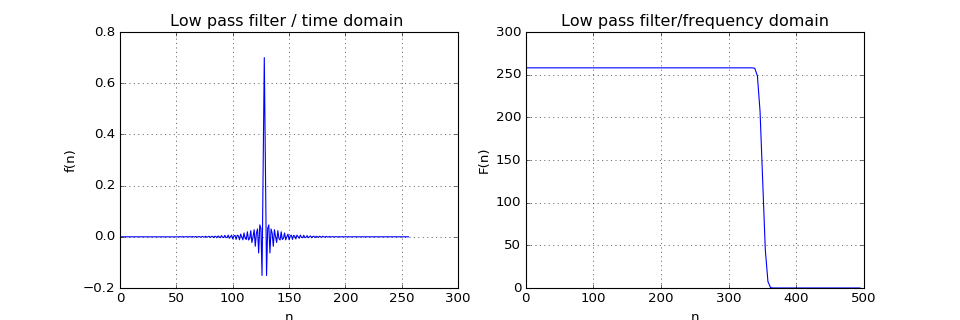

In [6]:
# Low Pass Filter
fout=flpw
m=128
dt=0.001
N=2*m+1
lpw=lpf(fout,m,dt)
_,Cn_lpw=fourierTransform(lpw)
Cn_lpw=Cn_lpw[:N/2]
Cn_lpw=Cn_lpw*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(lpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_lpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()

<IPython.core.display.Javascript object>


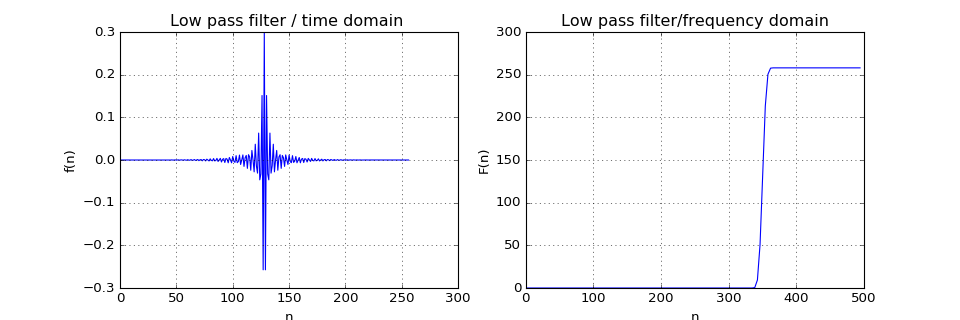

In [7]:
fc=fhpw
hpw=hpf(fc,m,dt)
_,Cn_hpw=fourierTransform(hpw)
Cn_hpw=Cn_hpw[:N/2]*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(hpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_hpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()

## Load Image

<IPython.core.display.Javascript object>


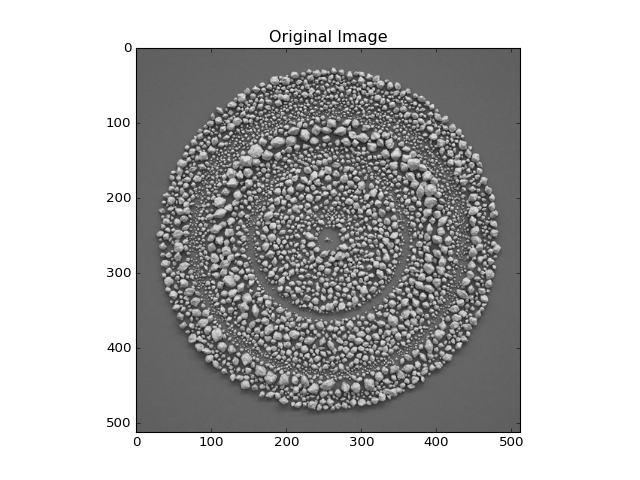

In [8]:
from PIL import Image
model = np.array(Image.open("./data/stones.jpg"))
model = (model-model.min())
size=model.shape
plt.figure()
plt.title('Original Image')
model=model[:,:,0]
imshow(model,cmap='gray')

<IPython.core.display.Javascript object>


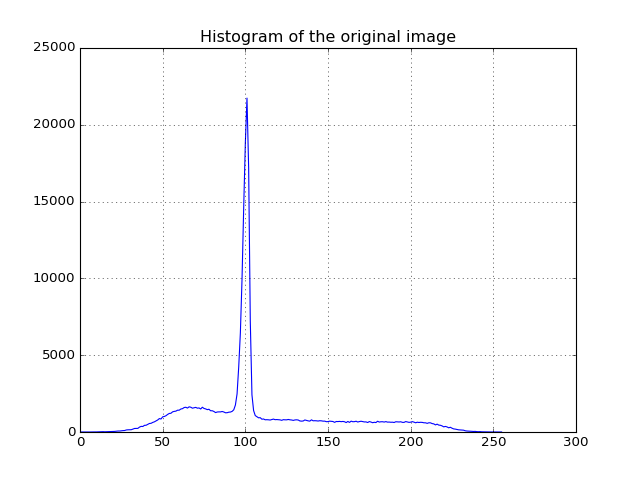

In [9]:
hist=[np.sum(model==i) for i in range(256)]
plt.figure()
plt.grid()
plt.title('Histogram of the original image')
plt.plot(hist)

In [103]:
model.shape

(512, 512)

### IV Apply Threshold transformation

<IPython.core.display.Javascript object>


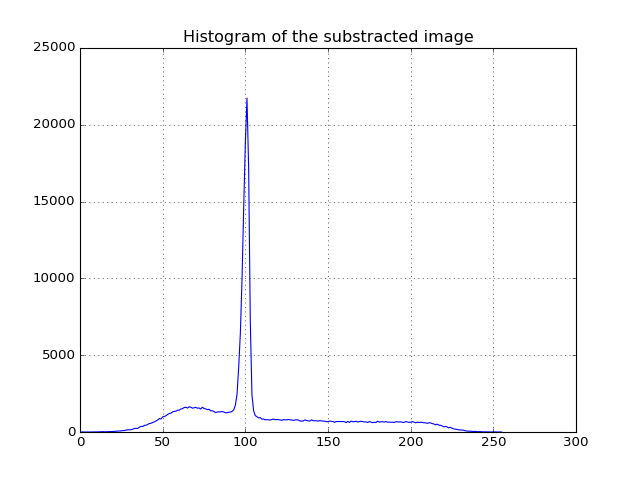

In [10]:
hist=[np.sum(model==i) for i in range(256)]
plt.figure()
plt.grid()
plt.title('Histogram of the substracted image')
plt.plot(hist)

<IPython.core.display.Javascript object>


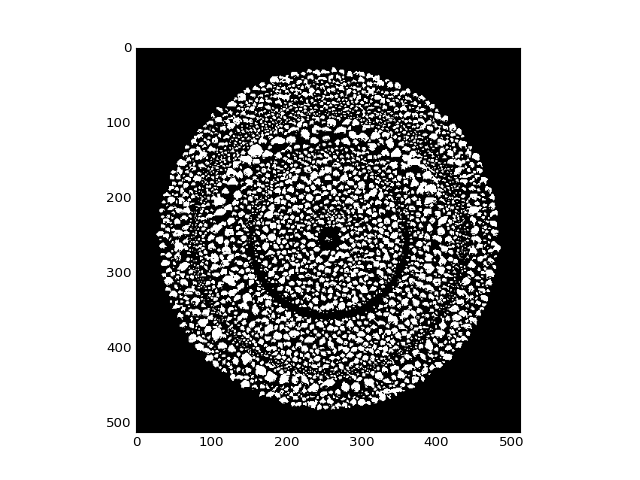

In [12]:
threshimg=np.copy(model)

threshimg[threshimg>=130]=255
threshimg[threshimg<90]=0
threshimg[np.multiply(threshimg>0 , threshimg<200)]=0

plt.figure()
imshow(threshimg,cmap='gray')

<IPython.core.display.Javascript object>


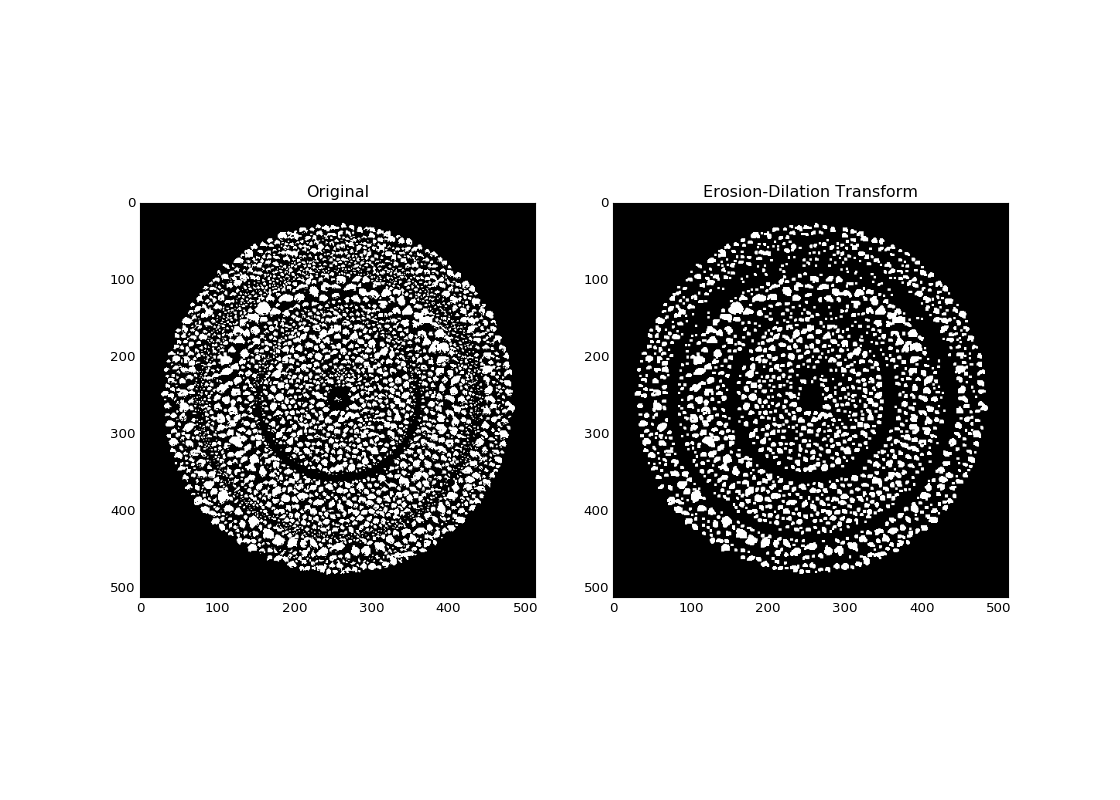

In [14]:
import cv2
import numpy as np

kernel = np.ones((3,3),np.uint8) # Morphological transformation
erosion = cv2.erode(threshimg,kernel,iterations = 1)
dilation = cv2.dilate(erosion,kernel,iterations = 1)

plt.figure(figsize=(14,10))
plt.subplot(1,2,2)
plt.title('Erosion-Dilation Transform')
imshow(dilation,cmap='gray')
plt.subplot(1,2,1)
plt.title('Original')
imshow(threshimg,cmap='gray')

In [15]:
final=threshimg

In [16]:
def findLinesH(arr):
    res=np.zeros_like(arr).astype('int32')
    h,w=arr.shape
    for i in range(h):
        for j in range(w):
            if res[i,j]>0 or arr[i,j]==0:
                continue
            jend=j
            while jend<w and arr[i,jend]==255:jend+=1
            res[i,j:jend]=jend-j
    return res
def findLinesV(arr):
    res=np.zeros_like(arr).astype('int32')
    h,w=arr.shape
    for i in range(h):
        for j in range(w):
            if res[i,j]>0 or arr[i,j]==0:
                continue
            iend=i
            while iend<h and arr[iend,j]==255:iend+=1
            res[i:iend,j]=iend-i
    return res

def setVisited(varr,imgseg,r,c):
    h,w=arr.shape
    if r<0 or r>=h:return
    if c<0 or c>=w:return
    if varr[r,c]==1:return
    if imgseg[r,c]==0:return
    
    varr[r,c]=1
    setVisited(arr,imgseg,r+1,c)
    setVisited(arr,imgseg,r-1,c)
    setVisited(arr,imgseg,r,c+1)
    setVisited(arr,imgseg,r,c-1)
    return varr

def getDimentions(varr,hlines,vlines,i,j):
    h,w=arr.shape
    if i<0 or i>=h:return
    if j<0 or j>=w:return
    if varr[i,j]==1:return
    if hlines[i,j]==0:return
    mxh,mxw=hlines[i,j],vlines[i,j]
    varr[i,j]=1
    nh,nw=getDimentions(varr,hlines,vlines,i+1,j)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i-1,j)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i,j+1)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i,j-1)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    return mxh,mxw

In [17]:
H=findLinesH(final)
V=findLinesV(final)

In [18]:
def getComponentDimensions(varr,imgseg,H,V,r,c):
    # varr: 1 if visited
    
    h,w=varr.shape
    if r<0 or r>=h:return -1,-1
    if c<0 or c>=w:return -1,-1
    if varr[r,c]==1:return -1,-1
    if imgseg[r,c]==0:return -1,-1
    
    varr[r,c]=1
    mxH,mxV=H[r,c],V[r,c]
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r+1,c)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r-1,c)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r,c+1)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r,c-1)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    return mxH,mxV

In [19]:
varr=np.zeros_like(final)
h,w=varr.shape
dimensions=[]
for i in range(h):
    for j in range(w):
        hl,vl=getComponentDimensions(varr,final,H,V,i,j)
        if hl>-1:
            dimensions.append((hl,vl))
            

In [20]:
dim=7
dimtups=[tup for tup in dimensions if max(tup[0],tup[1])==dim]
print("Number of stones: {}".format(len(dimensions)))
print("Number of stones of size {}: {}".format(dim,len(dimtups)))


Number of stones: 2846
Number of stones of size 7: 161
